**Reinforcement Learning with TensorFlow & TRFL: Deterministic Policy Gradients**

Outline:
1. Deep Deterministic Policy Gradients (DDPG) Overview
* TRFL Usage:

  * trfl.dpg()

  * trfl.td_learning()

  * trfl.update_target_variables()
  
3. Continuous Lunar Lander with DDPG




In [0]:
#TRFL works with TensorFlow 1.12
#installs TensorFlow version 1.12 then restarts the runtime
!pip install tensorflow==1.12

import os
os.kill(os.getpid(), 9)

In [0]:
#install tensorflow-probability 0.5.0 that works with TensorFlow 1.12
!pip install tensorflow-probability==0.5.0

#install TRFL
!pip install trfl

#install box2d for LunarLanding env
!pip install box2d-py

In [0]:
import gym
import tensorflow as tf
import trfl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [0]:
# replay buffer from and some code based on https://github.com/sfujim/TD3

# create replay buffer of tuples of (state, next_state, action, reward, done)
class ReplayBuffer(object):
	def __init__(self, max_size=1e6):
		self.storage = []
		self.max_size = max_size
		self.ptr = 0

	def add(self, data):
		if len(self.storage) == self.max_size:
			self.storage[int(self.ptr)] = data
			self.ptr = (self.ptr + 1) % self.max_size
		else:
			self.storage.append(data)

	def sample(self, batch_size):
		ind = np.random.randint(0, len(self.storage), size=batch_size)
		x, y, u, r, d = [], [], [], [], []

		for i in ind: 
			X, Y, U, R, D = self.storage[i]
			x.append(np.array(X, copy=False))
			y.append(np.array(Y, copy=False))
			u.append(np.array(U, copy=False))
			r.append(np.array(R, copy=False))
			d.append(np.array(D, copy=False))

		return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1,), np.array(d).reshape(-1,)
  

** DDPG Architecture **

In this example, we combine the actor and critic networks into one network. The outputs of both networks are inputted into trfl.dpg() where the deterministic policy gradients of the critic output with respect to the actor's action probabilities are found. The deterministic policy gradients are used to train the actor network.

DDPG is off-policy and combines some methods used for Deep Q Networks (DQN) like target network updating and an experience replay buffer. Unlike DQN, DDPG can be used in continuous action space. In this example, we train a DDPG network on continuous Lunar Lander.



In [0]:
# set up DDPG Network

class DDPGNetwork:
  def __init__(self, name, state_size=2, action_size=2, actor_hidden_size=32, actor_learning_rate=0.001, action_max=1., 
               dqda_clipping=None, clip_norm=False, critic_hidden_size=32, critic_learning_rate=0.001):

    with tf.variable_scope(name):
      self.name = name
      # placeholders for actor and critic networks
      self.input_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
      # placeholders for training critic network
      self.reward_ = tf.placeholder(tf.float32, [None], name='rewards' )
      self.discount_ = tf.placeholder(tf.float32, [None], name='discounts' )
      self.target_ = tf.placeholder(tf.float32, [None], name='target' )
      
      # actor network
      self.fc1_actor_ = tf.contrib.layers.fully_connected(self.input_, actor_hidden_size, activation_fn=tf.nn.relu)
      self.fc2_actor_ = tf.contrib.layers.fully_connected(self.fc1_actor_, actor_hidden_size, activation_fn=tf.nn.relu)
      self.fc3_actor_ = tf.contrib.layers.fully_connected(self.fc2_actor_, action_size, activation_fn=tf.nn.tanh)
      self.actor_out_ = self.fc3_actor_ * action_max
      
      # critic network
      # Note first layer is concatenation of state (self.input_) and action probabilities of that state (self.actor_out_)
      self.critic_input_ = tf.concat([self.input_, self.actor_out_], axis=1)
      self.fc1_critic_ = tf.contrib.layers.fully_connected(self.critic_input_, critic_hidden_size, activation_fn=tf.nn.relu)
      self.fc2_critic_ = tf.contrib.layers.fully_connected(self.fc1_critic_, critic_hidden_size, activation_fn=tf.nn.relu)
      self.critic_out_ = tf.contrib.layers.fully_connected(self.fc2_critic_, 1, activation_fn=None)
      
      # TRFL usage: deterministic policy gradients
      self.dpg_return_ = trfl.dpg(self.critic_out_, self.actor_out_, dqda_clipping=dqda_clipping, clip_norm=clip_norm)
      
      # train actor with DPG
      self.actor_loss_ = tf.reduce_mean(self.dpg_return_.loss)
      self.actor_optim_ = tf.train.AdamOptimizer(learning_rate=actor_learning_rate).minimize(self.actor_loss_)
      
      # train critic with TRFL td_learning. target is critic target network output of next state 
      self.td_return_ = trfl.td_learning(tf.squeeze(self.critic_out_), self.reward_, self.discount_, self.target_)
      self.critic_loss_ = tf.reduce_mean(self.td_return_.loss)
      self.critic_optim_ = tf.train.AdamOptimizer(learning_rate=critic_learning_rate).minimize(self.critic_loss_)
  
  # get variables for actor and critic networks for target network updating
  def get_network_variables(self):
    return [t for t in tf.trainable_variables() if t.name.startswith(self.name)]
    
      

** TRFL Usage: Deterministic Policy Gradients with trfl.dpg() and trfl.td_learning() **

We train the actor network part of DDPG with trfl.dpg(). We input the output of the critic network and the actor network into trfl.dpg() along with optional arguments for dqda_clipping and clip_norm. trfl.dpg() only optimizes the actor part of the network, hence the need for trfl.td_learning() and a separate optimizer for the critic part of the network.

We train the critic network part of DDPG using trfl.td_learning. Similar to section 1, the one step TD learning updates allows us to estimate our state values. One thing to note, is that in DDPG the critic takes not only the state as an input but also the action probabilities of the actor part of the network.





In [0]:
# hyperparameters
train_episodes = 5000    
discount = 0.99
batch_size = 32
replay_size = 50000
exploration_noise = 0.1

actor_hidden_size = 32
critic_hidden_size = 32
actor_learning_rate = 0.0005
critic_learning_rate = 0.0005
update_tau = 0.001
dqda_clipping = None
clip_norm = False

seed = 31
env = gym.make('LunarLanderContinuous-v2')
env.seed(seed)
np.random.seed(seed)
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]
action_max = env.action_space.high[0]

tf.reset_default_graph()
tf.set_random_seed(seed)

#create DDPG train and target networks
ddpg_net = DDPGNetwork("ddpg_train",state_size=state_size, action_size=action_size, actor_hidden_size=actor_hidden_size, 
                       actor_learning_rate=actor_learning_rate, action_max=env.action_space.high[0], dqda_clipping=dqda_clipping,
                       clip_norm=clip_norm, critic_hidden_size=critic_hidden_size, critic_learning_rate=critic_learning_rate)

ddpg_target_net = DDPGNetwork("ddpg_target",state_size=state_size, action_size=action_size, actor_hidden_size=actor_hidden_size, 
                       actor_learning_rate=actor_learning_rate, action_max=env.action_space.high[0], dqda_clipping=dqda_clipping,
                       clip_norm=clip_norm, critic_hidden_size=critic_hidden_size, critic_learning_rate=critic_learning_rate)

#target network update operations
target_network_update_op = trfl.update_target_variables(ddpg_target_net.get_network_variables(), 
                                                         ddpg_net.get_network_variables(), tau=update_tau)





** TRFL Usage **

For the target network updates we use trfl.update_target_variables() as we did in section 2. As originally done in the DDPG paper, we use incremental target updating every step. We perform target updating on the Actor and Critic variables.

** Reinforcement Learning Loop **

While the RL loop below will look largely similar to past examples, there are a few new things. One is that we use a hyperparameter called exploration_noise that is added to the action probabilities to allow better exploration. The second thing is the usage of a replay buffer and sampling from that buffer, similar to what we did with DQNs in section 2. DDPG is an off-policy method that uses a replay buffer, hence the training loop will have sections that gather experience and sections that train on that experience by sampling from the replay buffer. DDPG uses the target network to get targets that the train network uses for training.

In [0]:
# create replay buffer
replay_buffer = ReplayBuffer(max_size=replay_size)

stats_rewards_list = []
stats_every = 10
timesteps = 0
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    for ep in range(1, train_episodes):
        total_reward, ep_length, done = 0, 0, 0
        stats_actor_loss, stats_critic_loss = 0., 0.
        action_list, bootstrap_list = [], []

        state = env.reset()
        
        if len(stats_rewards_list) > 10 and np.mean(stats_rewards_list[-10:],axis=0)[1] > 190:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep,np.mean(stats_rewards_list[-10:],axis=0)[1]))
          break
          
        while not done:
            
            # generate action probabilities from actor part of the network)
            action = sess.run(ddpg_net.actor_out_, feed_dict={ddpg_net.input_: np.expand_dims(state,axis=0)})
            # add exploration noise (a hyperparamters)
            action = (action[0] + np.random.normal(0., exploration_noise, 
                       size=env.action_space.shape[0])).clip(env.action_space.low, env.action_space.high)
            
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            ep_length += 1
            timesteps += 1
            
            if total_reward < -250:
              done = 1
                
            # add experience to replay buffer
            replay_buffer.add((state, next_state, action, reward, done))
            
            # train the network
            if timesteps > batch_size:
              state_batch, next_state_batch, action_batch, reward_batch, done_batch = replay_buffer.sample(batch_size)
              
              #critic target
              target_v = sess.run(ddpg_target_net.critic_out_, feed_dict={
                  ddpg_target_net.input_: next_state_batch
              })
              # if done, no target value for next state
              target_v = np.reshape( (target_v * (1.-done)),(-1,))
                
              # train critic
              critic_loss, _ = sess.run([ddpg_net.critic_loss_, ddpg_net.critic_optim_], feed_dict={
                  ddpg_net.input_:state_batch,
                  ddpg_net.actor_out_:action_batch,
                  ddpg_net.reward_:reward_batch,
                  ddpg_net.discount_:np.array([discount]*batch_size),
                  ddpg_net.target_:target_v
              })
              
              # train actor
              actor_loss, _ = sess.run([ddpg_net.actor_loss_, ddpg_net.actor_optim_],feed_dict={
                  ddpg_net.input_:state_batch,                  
              })
                             
              # update target networks
              sess.run(target_network_update_op)
            
              # helps to see the actor and critic loss separately for debugging
              stats_actor_loss += actor_loss
              stats_critic_loss += critic_loss
              action_list.append(action)
              bootstrap_list.append(target_v)
            
              if done:
                if ep % stats_every == 0 and ep > 1:
                  print('Episode: {}'.format(ep),
                        'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                        'Ep length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                        'Actor loss: {:.5f}'.format(stats_actor_loss),
                        'Critic loss: {:.5f}'.format(stats_critic_loss))
                  #print(np.mean(bootstrap_list), np.mean(action_list,axis=1))
                stats_rewards_list.append((ep, total_reward, ep_length))
                break      
            else:
              if done:
                stats_rewards_list.append((ep, total_reward, ep_length))
                break
              
            state = next_state
         

Episode: 10 Total reward: -208.5 Ep length: 57.8 Actor loss: 32.83687 Critic loss: 1834.62029
Episode: 20 Total reward: -149.3 Ep length: 116.3 Actor loss: 263.26421 Critic loss: 5425.66052
Episode: 30 Total reward: -263.0 Ep length: 112.3 Actor loss: 317.27402 Critic loss: 2153.67057
Episode: 40 Total reward: -226.5 Ep length: 125.9 Actor loss: 711.13750 Critic loss: 2423.46262
Episode: 50 Total reward: -178.8 Ep length: 109.2 Actor loss: 807.25904 Critic loss: 5391.99116
Episode: 60 Total reward: -147.2 Ep length: 133.6 Actor loss: 388.91712 Critic loss: 1460.91714
Episode: 70 Total reward: -208.4 Ep length: 133.7 Actor loss: 629.18266 Critic loss: 3051.91813
Episode: 80 Total reward: -216.5 Ep length: 115.3 Actor loss: 2182.87774 Critic loss: 10639.50910
Episode: 90 Total reward: -171.2 Ep length: 151.9 Actor loss: 1056.75874 Critic loss: 7710.59995
Episode: 100 Total reward: -176.0 Ep length: 152.3 Actor loss: 1558.75544 Critic loss: 8233.99977
Episode: 110 Total reward: -186.4 Ep 

Text(0, 0.5, 'Total Reward')

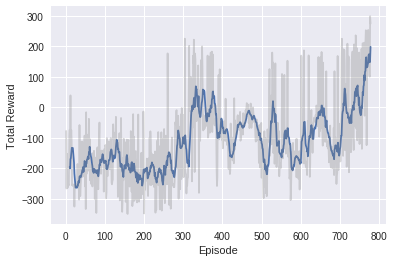

In [0]:
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews, lens = np.array(stats_rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')